In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Посмотрим распределение таргета в нашей выборке:

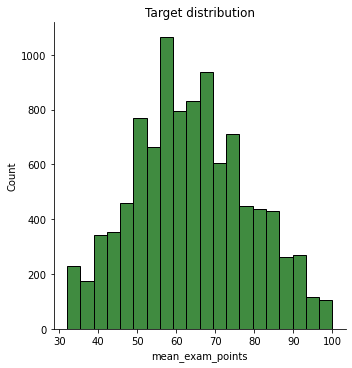

In [3]:
sns.displot(data['mean_exam_points'], bins=20, color='darkgreen').set(title='Target distribution');

N/A значений не имеется:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 937.6 KB


In [5]:
num_features = data.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])

Посмотрим на распределение остальных фич:

В целом, выбросов или ошибочных данных как таковых нет

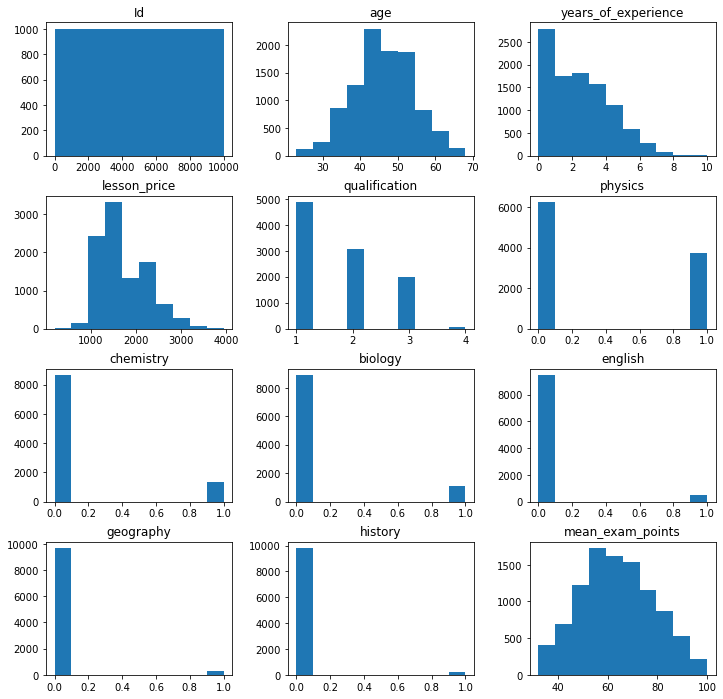

In [6]:
num_features.hist(figsize=(12, 12), bins=10, grid=False, log=False);

Посмотрим на матрицу корреляций признаков:

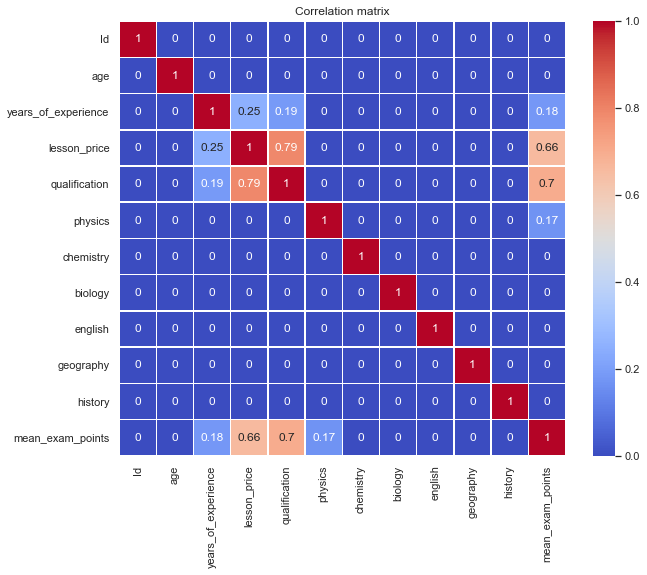

In [7]:
plt.figure(figsize = (10,8))

sns.set(font_scale=1)

corr_matrix = data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Отбросим колонку Id, чтобы она влияла на наши данные, и разобьем тренировочные данные на X и y

In [8]:
X_train = data.drop(columns=['mean_exam_points','Id'])
y_train = data['mean_exam_points']
test = test.drop(columns=['Id'])

Реализация стохастического градиентного бустинга на деревьях:

In [9]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch
        

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):  
        prediction = np.mean(self.labels)
        return prediction  

    
def mse(labels):
    mean = labels.mean()
    return np.mean((labels - mean)**2)

    
def gain(left_labels, right_labels, root_mse):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)


def split(data, labels, column_index, t):
    
    left = np.where(data.iloc[:, column_index] <= t)
    right = np.where(data.iloc[:, column_index] > t)
        
    true_data = data.iloc[left]
    false_data = data.iloc[right]
    
    true_labels = labels.iloc[left]
    false_labels = labels.iloc[right]
        
    return true_data, false_data, true_labels, false_labels


def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)

    false_branch = build_tree(false_data, false_labels)
    
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    
    classes = []
    for obj in data.values:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


def find_best_split(data, labels):
    
    min_samples_leaf = 80
    
    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique(data.iloc[:, index].values)
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
def r2(true, pred):
    return 1 - (sum((true - pred)**2)/len(true))/(sum((true - np.mean(true))**2)/len(true))


def gb_predict(X, trees_list, eta):
    
    predictions = np.array(
        sum([eta * np.array(predict(X, tree)) for tree in trees_list])
    )
    
    return predictions


def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)


def residual(y, z):
    return - (z - y)


def sgb_fit(n_trees, X_train, X_test, y_train, y_test, eta, size=0.5):
    
    
    trees = []
    size = int(np.floor(size*X_train.shape[0])) 
    
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        sample_index = np.random.randint(0, X_train.shape[0], size=size)

        
        if len(trees) == 0:
            tree = build_tree(X_train.iloc[sample_index], y_train.iloc[sample_index])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            target = gb_predict(X_train, trees, eta)

            tree = build_tree(X_train.iloc[sample_index], pd.Series(residual(np.array(y_train), target))[sample_index])

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
    
    return trees, train_errors, test_errors


def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} \
с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} \
с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Разбиваем датасет на тренировочные и тестовые данные. При поиске гиперпараметров я использовал test_size 0.3, а затем, когда параметры были подобраны, уменьшил тест сайз, чтобы модель обучилась на большем количестве тренировочных данных.

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=0.05,
                                                                    random_state=42)

In [49]:
%%time
n_trees = 15
eta = 0.205

sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, train_data, test_data, 
                                                       train_labels, test_labels, eta, size=0.5)

CPU times: user 1min 46s, sys: 1.1 s, total: 1min 47s
Wall time: 1min 49s


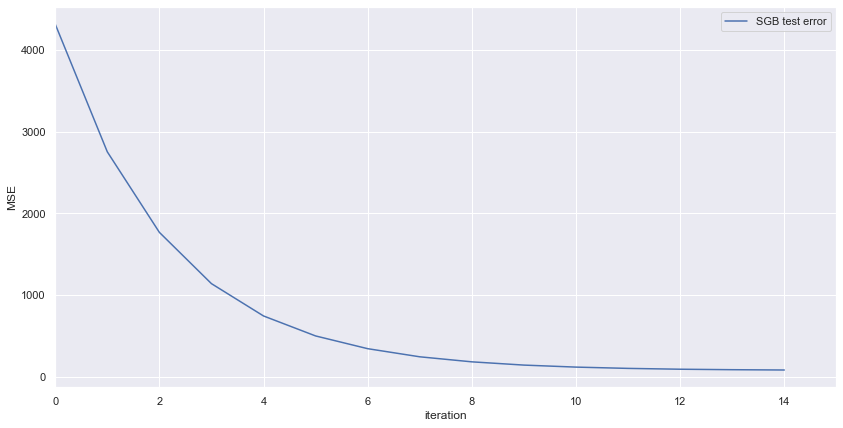

In [50]:
plt.figure(figsize = (14, 7))

plt.xlabel('iteration')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(sgb_test_errors, label='SGB test error')
plt.legend(loc='upper right')
plt.show();

In [60]:
evaluate_alg(train_data, test_data, train_labels, test_labels, sgb_trees, eta=0.212)

Ошибка алгоритма из 15 с шагом 0.212 на тренировочной выборке: 71.7538581890531
Ошибка алгоритма из 15 с шагом 0.212 на тестовой выборке: 73.37720033080281


In [74]:
predictions = gb_predict(train_data, sgb_trees, eta=0.212)

In [75]:
r2(list(train_labels), predictions)

0.6685805682346961

In [76]:
predictions = gb_predict(test_data, sgb_trees, eta=0.212)

In [77]:
r2(list(test_labels), predictions)

0.6521185860494003

In [78]:
predictions = gb_predict(test, sgb_trees, eta=0.212)

In [79]:
len(predictions)

10000

In [80]:
submission = pd.read_csv('sample_submission.csv')

In [81]:
submission['mean_exam_points'] = predictions

In [82]:
submission.to_csv('submit.csv', index=False)